In [64]:
from tkinter import *
from tkinter import ttk, filedialog
from tkinter.filedialog import askopenfilename
import csv
from pathlib import Path
import pymongo
import numpy as np
# Use sentinel for missing values
from numpy import nan as NA
import pandas as pd
# For showing plots in tkinter
import matplotlib.pyplot as plt
from matplotlib.figure import Figure 
from matplotlib.backends.backend_tkagg import (FigureCanvasTkAgg,  
NavigationToolbar2Tk) 
import seaborn as sns
import tkinter.constants as Tkconstants

# connect to mongodb
client = pymongo.MongoClient("mongodb://localhost:27017")
# create db
db_formative = client["summative"]
# create collection
collection_vendors = db_formative["test-180"]

In [65]:
class Parser(object):
    def __init__(self, csvFile):
        self.csvFile = csvFile
        
    def parseData(self):
        # Read CSV files and convert to Pandas DataFrames
        inspectionsDF = pd.read_csv(self.csvFile['inspections'], usecols=['ACTIVITY DATE', 'FACILITY ID', 'FACILITY NAME', 'PROGRAM STATUS', 'PE DESCRIPTION', 'FACILITY ZIP', 'SERIAL NUMBER', 'SCORE'])
        inventoryDF = pd.read_csv(self.csvFile['inventory'])
        violationsDF = pd.read_csv(self.csvFile['violations'], usecols=['SERIAL NUMBER', 'VIOLATION CODE'])
        
        return inspectionsDF, inventoryDF, violationsDF
                

In [66]:
class DataCleaner(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def clean(self):
        print('cleaning')
        self.cleanInspections()
        return self.inspectionsDF, self.inventoryDF, self.violationsDF
        
    def cleanInspections(self):
        # Extract info from PE DESC column and create new col for SEATING DETAILS
        self.inspectionsDF['SEATING DETAILS'] = self.inspectionsDF['PE DESCRIPTION'].str.extract(r"\(([\S ]+)\)")
        print(f'seating deats \n{self.inspectionsDF["SEATING DETAILS"]}')
        print(f'pe desc \n{self.inspectionsDF["PE DESCRIPTION"]}')
        # Extract first part of Zip Code (e.g. '90001-1234', becomes '90001')
        self.inspectionsDF['FACILITY ZIP'] = self.inspectionsDF['FACILITY ZIP'].str.extract(r"([0-9]+)") 
        # Add '_id' for MongoDB      
        self.inspectionsDF['_id'] = 'INS_' + self.inspectionsDF['SERIAL NUMBER']
        # Add '_id' for MongoDB
        self.violationsDF['_id'] = 'VIO_' + self.violationsDF.index.map(str) + '_' + self.violationsDF['SERIAL NUMBER']


In [67]:
class DataLoader(object):
    def __init__(self, inspections, inventory, violations):
        self.inspectionsDF = inspections
        self.inventoryDF = inventory
        self.violationsDF = violations
        
    def loadToMongo(self):
        # use to_dict to format correctly for MongoDB
        inspectionsDict = self.inspectionsDF.to_dict(orient='records')
        inventoryDict = self.inventoryDF.to_dict(orient='records')
        violationsDict = self.violationsDF.to_dict(orient='records')
        # Insert into Mongo
        collection_vendors.insert_many(inspectionsDict)
    #   collection_vendors.insert_many(inventoryDict)
        collection_vendors.insert_many(violationsDict)
        # Test db
        test = collection_vendors.find({'_id':{'$regex':'INS_'}})
        for t in test:
            print(f'testing inspections: \n{t}')
            break
        print('inserted into Mongo')
     
           

In [68]:
class ButtonUpload(object):
    def __init__(self, fileButtons, fileLabels, counter, mainframe, fileRoutes):
        self.fileButtons = fileButtons
        self.fileLabels = fileLabels
        self.counter = counter
        self.mainframe = mainframe
        self.fileRoutes = fileRoutes
        self.filePath = ''
        self.uploadLabel = StringVar()

    def browseFile(self):
        self.filePath = askopenfilename(filetypes=[("CSV files", ".csv")])
        fileName = Path(self.filePath)
        self.uploadLabel.set(fileName.name)
        print(self.filePath)
        self.setFileRoutes()
    
    def setFileRoutes(self):
        self.fileRoutes[self.fileButtons] = self.filePath
        print(self.fileRoutes)
        
    def createButton(self):
        ttk.Label(self.mainframe, text=f"Upload data: {self.fileButtons}", anchor="w").grid(row=self.counter+1, column=0, sticky="w")
        Button(self.mainframe, text="Upload file", command=self.browseFile).grid(row=self.counter+1, column=1, sticky="w")
        ttk.Label(self.mainframe, textvariable=self.uploadLabel).grid(row=self.counter+1, column=2, sticky="w") 
        

In [69]:
class AveragesCalculator(object):
    def __init__(self, year, category):
        self.year = year
        self.category = category
        
    def zipScores(self):
        print(f'Calculating stats for: \n- Year = {self.year} \n- Category = {self.category}')
        # Find inspection documents - look in ispections (INS_) with year
        resultsInspections = collection_vendors.find({'_id':{'$regex':'INS_'},'ACTIVITY DATE':{'$regex':self.year}, 'PROGRAM STATUS': 'ACTIVE'})

        # Create dict of facility zips with lists of their scores
        zipScoresDict = {}  
        for r in resultsInspections:
            key = r[self.category]
            if key in zipScoresDict:
                zipScoresDict[r[self.category]].append(r['SCORE'])
            else:
                zipScoresDict[key] = [r['SCORE']]
        return self.calcZipStats(zipScoresDict)


    def calcZipStats(self, zipScoresDict):
        zipScoresMean = {}
        zipScoresMean = {self.category:[],'mean':[],'median':[],'mode':[]}
        for x in zipScoresDict:
            # Create Series to calc mean, mode, median
            tempSeries = pd.Series(zipScoresDict[x])
            mean = tempSeries.mean()
            mode = tempSeries.mode().tolist()
            median = tempSeries.median()

            # mean, mode, median as columns
            zipScoresMean[self.category].append(x)
            zipScoresMean['mean'].append(mean)
            zipScoresMean['median'].append(median)
            zipScoresMean['mode'].append(mode)

        # Create DataFrame
        zipScoresDF = pd.DataFrame(zipScoresMean)
        # sort by ascending cat - easier to find for user (esp. zip)
        zipScoresDF.sort_values(by=[self.category],inplace=True)
        # set cat as index
        zipScores_noIndex = zipScoresDF.set_index(self.category)
        
        return zipScores_noIndex
 

In [70]:
class ViolationsPlot(object):
    def __init__(self, tab):
        self.tab = tab
        
    def processData(self):
        violationsAgg = collection_vendors.aggregate([
            {'$group': {'_id': '$SERIAL NUMBER', 'FACILITY ID': {'$addToSet': '$FACILITY ID'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
        ])
        # Find out what violations were committed by each facility
        # Use a set() to get unique entries 
        # (violations may be committed multiple times by same facility but I only want to count that facility once)
        facilityViolations = {}
        for item in violationsAgg:
            try:
                if item['FACILITY ID'][0] in facilityViolations:
                    facilityViolations[item['FACILITY ID'][0]].update(item['VIOLATIONS'])
                else:
                    facilityViolations[item['FACILITY ID'][0]] = set()
                    facilityViolations[item['FACILITY ID'][0]].update(item['VIOLATIONS'])
            # Possible error - some violations have serial numbers that are not recorded in Inspections data.
            # These are not used in plots because they do not correspond to a facility.
            except Exception as e:
                print(f'Error: "{e}". Cannot add this item to dictionary: {item["_id"]}')

        uniqueVCodes = {}
        for facility in facilityViolations:
            for vCode in facilityViolations[facility]:
                if vCode in uniqueVCodes:
                    uniqueVCodes[vCode] = uniqueVCodes[vCode] + 1
                else:
                    uniqueVCodes[vCode] = 1 
                    
        # Convert data to DataFrame and sort the data descending by value
        data = {'keys':list(uniqueVCodes.keys()), 'values':list(uniqueVCodes.values())}
        uniqueVCodesDF = pd.DataFrame(data)
        uniqueVCodesDF.sort_values(by='values',ascending=False,inplace=True)
        print(uniqueVCodesDF)
        self.createPlot(uniqueVCodesDF)
    
    def createPlot(self, uniqueVCodesDF):
        # Display violations vs no. of establishments
        vioKeys = uniqueVCodesDF['keys']
        vioVals = uniqueVCodesDF['values']
        # Create 4 subplots using slices of the keys & values lists
        fig,a =  plt.subplots(2,2)
        a[0][0].bar(vioKeys[:round(len(vioKeys)*0.25)], vioVals[:round(len(vioKeys)*0.25)])
        a[0][1].bar(vioKeys[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)], vioVals[round(len(vioKeys)*0.25):round(len(vioKeys)*0.5)])
        a[1][0].bar(vioKeys[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)], vioVals[round(len(vioKeys)*0.5):round(len(vioKeys)*0.75)])
        a[1][1].bar(vioKeys[round(len(vioKeys)*0.75):], vioVals[round(len(vioKeys)*0.75):])
        # Tidy plot - rotate labels & apply layout
        a[0][0].tick_params(axis='x',labelrotation=45)
        a[0][1].tick_params(axis='x',labelrotation=45)
        a[1][0].tick_params(axis='x',labelrotation=45)
        a[1][1].tick_params(axis='x',labelrotation=45)
        plt.tight_layout()
        # Show in console as well as window
        plt.show()
        # creating the Tkinter canvas containing the Matplotlib figure 
        canvas = FigureCanvasTkAgg(fig, master = self.tab)   
        canvas.draw() 
        # grid the canvas on the Tkinter window 
        canvas.get_tk_widget().place(relheight=1, relwidth=1) 


In [71]:
class CorrelationsPlot(object):
    def __init__(self, title):
        self.title = title
        
    def processData(self):
        # find the violations with fac name and zip
        violationsZipAgg = collection_vendors.aggregate([
            {'$group': {'_id': '$SERIAL NUMBER','ZIP': {'$addToSet':'$FACILITY ZIP'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
        ])
        # Create dict with zip code: [violations no. per facility]
        vioDict = {}
        for item in violationsZipAgg:
            try:
                zipCode = item['ZIP'][0] + ' -'
                if zipCode in vioDict:
                    vioDict[zipCode].append(len(item['VIOLATIONS']))
                else:
                    vioDict[zipCode] = [len(item['VIOLATIONS'])]
            # Possible error - some violations have serial numbers that are not recorded in Inspections data.
            # These are not used in plots because they do not correspond to a facility.
            except Exception as e:
                print(f'Error: "{e}". Cannot add this item to dictionary: {item["_id"]}')

        # Calc mean for violation no.
        for v in vioDict:
            tempSeries = pd.Series(vioDict[v])
            mean = tempSeries.mean()
            vioDict[v] = mean
            
        #  Create DataFrame - sorted by zip to make visualisations easier to understand
        data = {
            'quantity': list(vioDict.values()),
            'zip': list(vioDict.keys())
        }
        insViosDF = pd.DataFrame(data)
        insViosDF.sort_values(by=['quantity'],ascending=False,inplace=True)
        print(insViosDF)
        self.createPlot(insViosDF)
    
    def createPlot(self, insViosDF):
        # New window
        window = Tk()
        window.title(self.title)
        window.geometry("1200x800")
        window.columnconfigure(0, weight=1)
        window.rowconfigure(0, weight=1)
        
        # Scroll Y
        frame=Frame(window)
        frame.grid(row=0,column=0)
        frame.columnconfigure(0, weight=1)
        frame.rowconfigure(0, weight=1)
        canvas = Canvas(frame)
        canvas.grid(row=0, column=0)
        yScrollbar = Scrollbar(frame)
        yScrollbar.grid(row=0, column=1, sticky=Tkconstants.NS)
        canvas.config(yscrollcommand=yScrollbar.set)
        yScrollbar.config(command=canvas.yview)
        
        # Creating the figure and Seaborn plot
        figure = Figure(figsize=(8, 40))
        ax = figure.subplots()
        sns.barplot(x="quantity", y="zip", data=insViosDF, label="Total", color="b", ax=ax, ci=None)
        
        # create the Tkinter canvas 
        canvasInner = FigureCanvasTkAgg(figure, master = canvas)   
        canvasInner.draw() 

        # place the canvas on the Tkinter window 
        mplCanvas = canvasInner.get_tk_widget()
        
        cwid = canvas.create_window(0, 0, window=mplCanvas, anchor=Tkconstants.NW)
        canvas.config(scrollregion=canvas.bbox(Tkconstants.ALL),width=800,height=800)
        

In [72]:
class UserInterface(object):
    def __init__(self, title):
        self.title = title
        self.mainframe = None
        self.window = Tk()
        self.window.title(self.title)
        self.window.geometry("1200x800")
        self.window.columnconfigure(0, weight=1)
        self.window.rowconfigure(0, weight=1)
        self.calcCategory = StringVar()
        self.calcYear = StringVar()
        self.cleanedData = None
        self.fileButtons = ["inspections", "inventory", "violations"]
        self.fileRoutes = {self.fileButtons[0]:"", self.fileButtons[1]:"", self.fileButtons[2]:""}
        
    def createWindow(self):
        self.createInitialFrame()
        self.window.mainloop()
        
    def createInitialFrame(self):
         # variables
        labelTextOne = StringVar()
        labelTextTwo = StringVar()
        labelTextThree = StringVar()
        fileLabels = [labelTextOne, labelTextTwo, labelTextThree]
        # Config layout
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        self.mainframe.grid_rowconfigure(4, weight=1)
        self.mainframe.grid_columnconfigure(2, weight=1)
        heading = ttk.Label(self.mainframe, text="Load your dataset", anchor="w").grid(row=0, sticky="nw")
        # Create buttons for file uploads
        for i in range(0, len(self.fileButtons)): 
            newButton = ButtonUpload(self.fileButtons[i], fileLabels[i], i, self.mainframe, self.fileRoutes)
            newButton.createButton()
        # Buttons for Cancel and Clean & Save
        footer = ttk.Frame(self.window, padding="16 0 0 0").grid(row=5, column=1)
        cancelButton = Button(self.mainframe, text="Cancel & exit", bg="red").grid(row=4, column=0, sticky="sw")
        saveButton = Button(self.mainframe, text="Load & clean dataset", command=self.handleSave).grid(row=4, column=2,sticky="se")
        
    def handleSave(self):
        # parse data
        parser = Parser(self.fileRoutes)
        try:
            parsedData = parser.parseData()
        # Catch errors - data with incorrect columns with throw error
        except ValueError:
            print('Value error - incorrect data entered.')
            messagebox.showerror("Error", f"Value Error, please make sure you are uploading the correct data. \n{sys.exc_info()[0]}")
            return
        except:
            print("Unexpected Error", sys.exc_info()[0])
            messagebox.showerror("Error", f"Unexpected Error, please try again. \n{sys.exc_info()[0]}")
            return
        # Clean data - pass data returned from parser
        cleaner = DataCleaner(*parsedData)
        self.cleanedData = cleaner.clean()
        print('done handleSave')
        self.uploadFrame()
        
    def uploadFrame(self):
        self.mainframe.destroy()
        self.mainframe = ttk.Frame(self.window, padding="16 16 16 16")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        heading = ttk.Label(self.mainframe, text="The data has been prepared and cleaned.", anchor="w").grid(row=0, sticky="nw")
        subheading = ttk.Label(self.mainframe, text="Please press continue to load data to MongoDB and proceed.", anchor="w").grid(row=1, sticky="nw")
        saveButton = Button(self.mainframe, text="Continue", command=self.handleLoadToDB).grid(row=2 ,sticky="nw")
        print('done uploadFrame')
        
    def handleLoadToDB(self):
        # Insert to MongoDB - pass data returned from cleaner
        loader = DataLoader(*self.cleanedData)
        try:
            loader.loadToMongo()
            print('done handleLoadToDB')
        # Catch errors - if collection already has this data, it will throw a duplicate key error
        except:
            print("Unexpected Error", sys.exc_info()[0])
            self.createInitialFrame()
            messagebox.showerror("Error", f"Unexpected Error, please try again \n{sys.exc_info()[0]}")
            return
        self.createNotebook()
        
    def createNotebook(self):
        print('Creating Notebook (Tabs)')
        self.mainframe.destroy()
        self.mainframe = ttk.Notebook(self.window)
        f1 = ttk.Frame(self.mainframe)  
        f2 = ttk.Frame(self.mainframe)  
        f3 = ttk.Frame(self.mainframe) 
        self.mainframe.add(f1, text='Averages')
        self.mainframe.add(f2, text='Violations per Establishment')
        self.mainframe.add(f3, text='Correlations')
        # ====== Widget for tab 1
        heading_one = ttk.Label(f1, text="Mean, Mode and Median", anchor="w").grid(row=0, sticky="nw")
        # Radio - Type
        radioHeadingOne = ttk.Label(f1, text="Calculate by seating type or zip codes:", anchor="w").grid(row=0, sticky="nw")
        Radiobutton(f1, text="Vendor seating type", padx = 20, variable=self.calcCategory, value='SEATING DETAILS').grid(row=1, column=0, sticky='w')
        Radiobutton(f1, text="Zip Code", padx = 20, variable=self.calcCategory, value='FACILITY ZIP').grid(row=2, column=0, sticky='w')
        # Radio - Years
        radioHeadingTwo = ttk.Label(f1, text="Select Year", anchor="w").grid(row=3, sticky="nw")
        yearsArr = ['2016', '2017', '2018', '2019']
        for i in range(len(yearsArr)):
            Radiobutton(f1, text=yearsArr[i], padx = 20, variable=self.calcYear, value=yearsArr[i]).grid(row=i+4, column=0, sticky='w')
        # Calc button
        calcButton = Button(f1, text="Calculate", command=self.calcAverages).grid(row=8, column=0, sticky="sw")
        self.mainframe.grid(column=0, row=0, sticky=(N, W, E, S))
        
        # ====== Widget for tab 2
        heading_two = ttk.Label(f2, text="Number of establishments that have committed each type of violation.", anchor="w").grid(row=0, sticky="nw")
        violationsButton = Button(f2, text="Show violations plot", command=lambda:self.createViolationsPlot(f2)).grid(row=1, column=0, sticky="sw")
        
        # ====== Widget for tab 3
        heading_two = ttk.Label(f3, text="Correlation between the number of violations commited per vendor and their zip code", anchor="w").grid(row=0, sticky="nw")
        correlationsButton = Button(f3, text="Show correlations plot", command=self.createCorrelationsPlot).grid(row=1, column=0, sticky="sw")
        
    def createViolationsPlot(self, f2):
        vPlot = ViolationsPlot(f2)
        vPlot.processData()
        
    def createCorrelationsPlot(self):    
        title = "Violations commited per vendor and their zip code"
        cPlot = CorrelationsPlot(title)
        cPlot.processData()
    
    def calcAverages(self):
        calcCatVal = self.calcCategory.get()
        calcYearVal = self.calcYear.get()
        calcAv = AveragesCalculator(calcYearVal, calcCatVal)
        avResults = calcAv.zipScores()
        self.averagesResultsFrame(avResults, calcYearVal, calcCatVal)
        
    def averagesResultsFrame(self, resultsAv, calcYearVal, calcCatVal):
        avResultsWindow = Tk()
        avResultsWindow.title(f'Averages Results for {calcCatVal} in {calcYearVal}')
        avResultsWindow.geometry("600x400")
        mainframe = ttk.Frame(avResultsWindow, padding="16 16 16 16")
        mainframe.place(relheight=1, relwidth=1)

        tree = ttk.Treeview(mainframe)
        tree.place(relheight=1, relwidth=1)
        treescrolly = Scrollbar(mainframe, orient='vertical', command=tree.yview)
        treescrollx = Scrollbar(mainframe, orient='horizontal', command=tree.xview)
        tree.configure(xscrollcommand=treescrollx.set, yscrollcommand=treescrolly.set)
        treescrolly.pack(side='right', fill='y')
        treescrollx.pack(side='bottom', fill='x')

        tree["columns"]=("one","two","three")
        tree.column("#0", width=75, minwidth=75)
        tree.column("one", width=75, minwidth=75)
        tree.column("two", width=75, minwidth=75)
        tree.column("three", width=75, minwidth=75)

        tree.heading("#0",text="Category")
        tree.heading("one", text="Mean")
        tree.heading("two", text="Median")
        tree.heading("three", text="Mode")

        for index, row in resultsAv.iterrows(): 
            tree.insert('','end', text=index, values=[row['mean'],row['median'],row['mode']])
        print(f'This is resultsAv: \n{resultsAv}')
 

/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inventory_sm.csv', 'violations': ''}
/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/violations_md.csv
{'inspections': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_data/Inspections_md.csv', 'inventory': '/Users/ericagoodwin/Documents/york-msc/Module 8 - Advanced Programming/Week 6/training_d

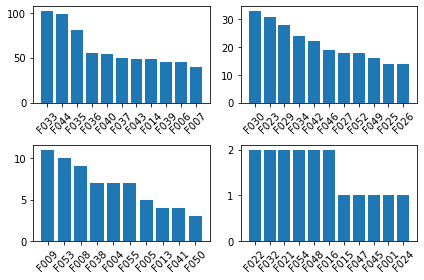

In [73]:
ui = UserInterface('summative')
ui.createWindow()

In [38]:
data = {'dates':['08/23/2018', '08/23/2019', '08/23/2020']}
df = pd.DataFrame(data)
# dt = d.to_datetime()
dates = pd.to_datetime(df['dates'])

In [6]:
dates

0   2018-08-23
1   2019-08-23
2   2020-08-23
Name: dates, dtype: datetime64[ns]

In [42]:
# find the violations with fac name and zip
newCol = collection_vendors.aggregate([
    {'$group': {'_id': '$SERIAL NUMBER', 'FACILITY NAME': {'$addToSet':'$FACILITY NAME'},'ZIP': {'$addToSet':'$FACILITY ZIP'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
])
# Create dict with zip code: [violations no. per facility]
vioDict = {}
for n in newCol:
    try:
        zipCode = n['ZIP'][0] + ' -'
        if zipCode in vioDict:
            vioDict[zipCode].append(len(n['VIOLATIONS']))
        else:
            vioDict[zipCode] = [len(n['VIOLATIONS'])]
    # Possible error - some violations have serial numbers that are not recorded in Inspections data.
    # These are not used in plots because they do not correspond to a facility.
    except Exception as e:
        print(f'Error: "{e}". Cannot add this item to dictionary: {n["_id"]}')
    

Error: "list index out of range". Cannot add this item to dictionary: DABU3EZIK
Error: "list index out of range". Cannot add this item to dictionary: DANAQZ8D0
Error: "list index out of range". Cannot add this item to dictionary: DAGUODRUS
Error: "list index out of range". Cannot add this item to dictionary: DANKRSOT0
Error: "list index out of range". Cannot add this item to dictionary: DAZ7BQS19
Error: "list index out of range". Cannot add this item to dictionary: DAVSHLLVX
Error: "list index out of range". Cannot add this item to dictionary: DAAMAVQCR
Error: "list index out of range". Cannot add this item to dictionary: DA4I640TU
Error: "list index out of range". Cannot add this item to dictionary: DATMDBCNS
Error: "list index out of range". Cannot add this item to dictionary: DAIYOORS7
Error: "list index out of range". Cannot add this item to dictionary: DAHA0XGHM
Error: "list index out of range". Cannot add this item to dictionary: DAOPGOEYY
Error: "list index out of range". Cannot

In [41]:
violationsAgg = collection_vendors.aggregate([
    {'$group': {'_id': '$SERIAL NUMBER', 'FACILITY ID': {'$addToSet': '$FACILITY ID'}, 'VIOLATIONS': {'$addToSet': '$VIOLATION CODE'}}}
])
# Find out what violations were committed by each facility
# Use a set() to get unique entries 
# (violations may be committed multiple times by same facility but I only want to count that facility once)
facilityViolations = {}
for item in violationsAgg:
    try:
        if item['FACILITY ID'][0] in facilityViolations:
            facilityViolations[item['FACILITY ID'][0]].update(item['VIOLATIONS'])
        else:
            facilityViolations[item['FACILITY ID'][0]] = set()
            facilityViolations[item['FACILITY ID'][0]].update(item['VIOLATIONS'])
    # Possible error - some violations have serial numbers that are not recorded in Inspections data.
    # These are not used in plots because they do not correspond to a facility.
    except Exception as e:
        print(f'Error: "{e}". Cannot add this item to dictionary: {item["_id"]}')

Error: "list index out of range". Cannot add this item to dictionary: DABU3EZIK
Error: "list index out of range". Cannot add this item to dictionary: DANAQZ8D0
Error: "list index out of range". Cannot add this item to dictionary: DAGUODRUS
Error: "list index out of range". Cannot add this item to dictionary: DANKRSOT0
Error: "list index out of range". Cannot add this item to dictionary: DAZ7BQS19
Error: "list index out of range". Cannot add this item to dictionary: DAVSHLLVX
Error: "list index out of range". Cannot add this item to dictionary: DAAMAVQCR
Error: "list index out of range". Cannot add this item to dictionary: DA4I640TU
Error: "list index out of range". Cannot add this item to dictionary: DATMDBCNS
Error: "list index out of range". Cannot add this item to dictionary: DAIYOORS7
Error: "list index out of range". Cannot add this item to dictionary: DAHA0XGHM
Error: "list index out of range". Cannot add this item to dictionary: DAOPGOEYY
Error: "list index out of range". Cannot